In [1]:
import scanpy as sc
import surgeon
import numpy as np

Using TensorFlow backend.


In [2]:
sc.settings.set_figure_params(dpi=200, frameon=False)

In [3]:
condition_key = "study"
cell_type_key = 'cell_type'

# Loading 26 Panorama datasets and data preparation

In [4]:
adata = sc.read("./data/panorama/panorama_count.h5ad")
adata

AnnData object with n_obs × n_vars = 122816 × 2000 
    obs: 'batch', 'cell_type', 'study'

## Number of cells in each batch & cell type

In [5]:
adata.obs[condition_key].value_counts()

Macrophage Uninfected     18130
PBMC 68K                  18006
Macrophage Infected       11989
Neuron9K                   9032
Pancreas inDrop            8569
CD56 NK                    6657
Jurkat 293t 99:1           4185
Cytotoxic T Cells          3990
PBMC Kang                  3774
CD4 T Helper               3713
Memory T Cells             3628
Jurkat 293t 50:50          3388
Regulatory T Cells         3365
Jurkat                     3257
Pancreas SS2               2989
293t                       2885
Pancreas CelSeq2           2449
HSC Mars                   2401
PBMC 10X                   2293
B Cells                    2261
Macrophage Mixed           2174
Pancreas Celseq            1276
HSC SS2                     774
Macrophage Uninfected2      698
Pancreas Fluidigm C1        638
CD14 Monocytes              295
Name: study, dtype: int64

In [6]:
adata.obs[cell_type_key].value_counts()

Macrophage                  32991
PBMC T cells                18006
PBMC CD4 T cells            10706
Jurkat                       9225
Neuron                       9032
PBMC CD56+ NK                6978
PBMC CD14+ monocyte          4905
Pancreas Beta                4765
Pancreas Alpha               4704
293t                         4490
PBMC CD8 T cells             3990
PBMC CD19+ B cells           3397
Pancreas Ductal              2104
Hsc MEP                      1394
Hsc GMP                      1183
Pancreas Delta               1041
Pancreas Endothelial          836
Pancreas Acinar               713
Pancreas Gamma                637
Hsc CMP                       590
Pancreas Stellate             561
Pancreas Beta(ER stress)      320
Pancreas Unkonwn              240
Hsc Unknown                     8
Name: cell_type, dtype: int64

## visualization  of the original data

In [7]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


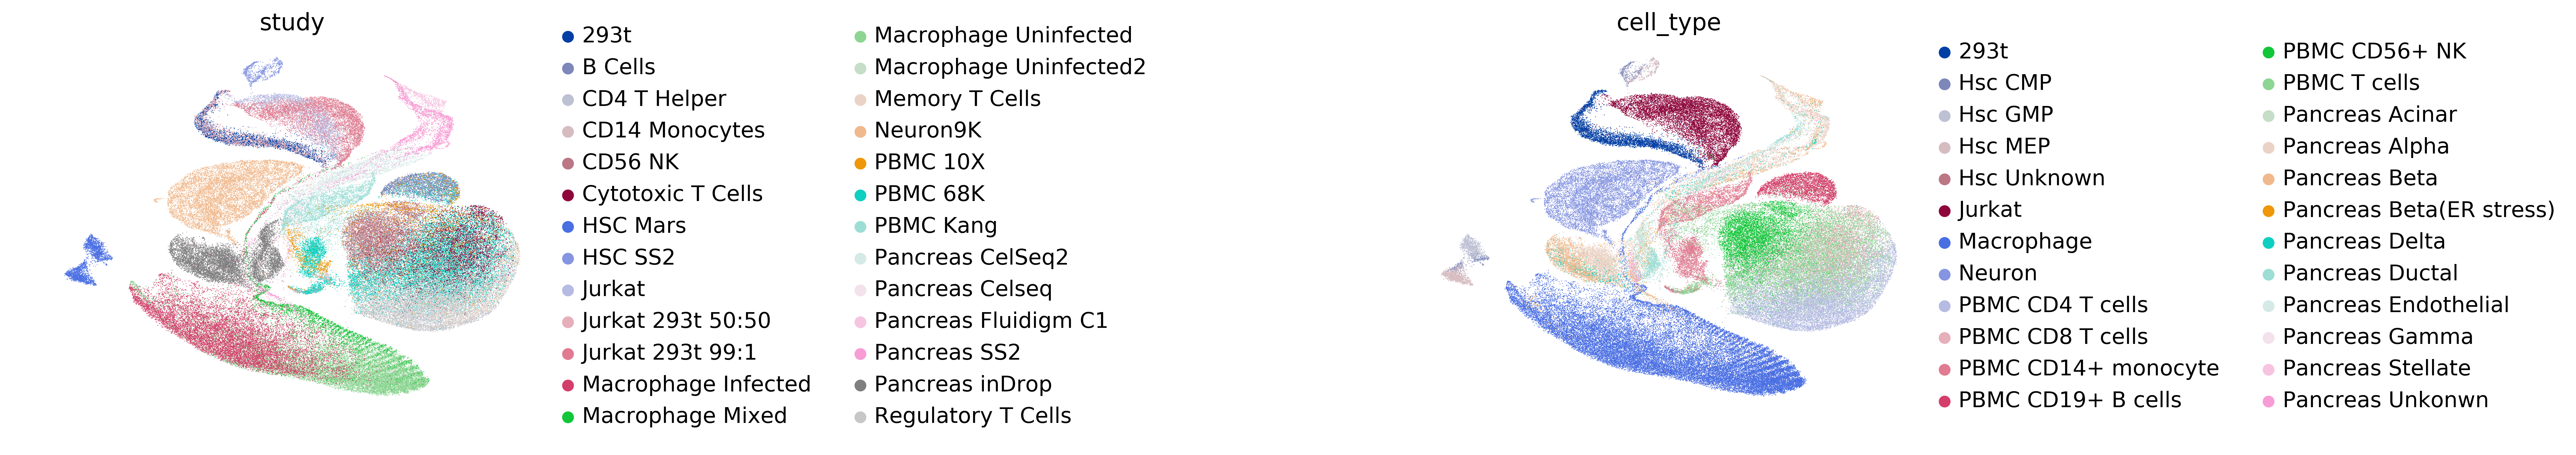

In [8]:
sc.pl.umap(adata, color=[condition_key, cell_type_key], wspace=1.5)

## Normalization

In [9]:
adata = surgeon.utils.normalize(adata, 
                                 filter_min_counts=False, 
                                 normalize_input=False, 
                                 size_factors=True,
                                 logtrans_input=True,
                                 n_top_genes=2000,
                                )
adata

AnnData object with n_obs × n_vars = 122816 × 2000 
    obs: 'batch', 'cell_type', 'study', 'n_counts', 'size_factors'
    uns: 'neighbors', 'study_colors', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap'

## Train/Test Split

In [10]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata, 0.85)

In [11]:
train_adata.shape, valid_adata.shape

((104393, 2000), (18423, 2000))

In [12]:
n_conditions = len(train_adata.obs[condition_key].unique().tolist())

# Create & Train model with training data

In [13]:
network = surgeon.archs.CVAE(x_dimension=train_adata.shape[1], 
                             z_dimension=40,
                             n_conditions=n_conditions,
                             lr=0.001,
                             alpha=0.0001,
                             scale_factor=1.0,
                             clip_value=3.0,
                             loss_fn='nb',
                             model_path="./models/CVAE/before-Panorama/",
                             dropout_rate=0.2,
                             output_activation='relu')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/home/mohsen/scnet/surgeon/models/_cvae.py:143: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`
  output=h_disp)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 2000)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 26)           0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 2026)         0           data[0][0]                       
                                                                 encoder_labels[0][0]             
__________________________________________________________________________________________________
first_layer (Dense)             (None, 128)          259328      concatenate_1[0][0]              
__________

## We assign each study to a numerical label 

In [14]:
condition_encoder = surgeon.tl.create_dictionary(adata.obs[condition_key].unique().tolist(), None)
condition_encoder

{'293t': 0,
 'Jurkat': 1,
 'Jurkat 293t 50:50': 2,
 'Jurkat 293t 99:1': 3,
 'Neuron9K': 4,
 'HSC Mars': 5,
 'HSC SS2': 6,
 'Macrophage Uninfected': 7,
 'Macrophage Uninfected2': 8,
 'Macrophage Infected': 9,
 'Macrophage Mixed': 10,
 'Pancreas inDrop': 11,
 'Pancreas CelSeq2': 12,
 'Pancreas Celseq': 13,
 'Pancreas Fluidigm C1': 14,
 'Pancreas SS2': 15,
 'PBMC 68K': 16,
 'B Cells': 17,
 'CD14 Monocytes': 18,
 'CD4 T Helper': 19,
 'CD56 NK': 20,
 'Cytotoxic T Cells': 21,
 'Memory T Cells': 22,
 'Regulatory T Cells': 23,
 'PBMC Kang': 24,
 'PBMC 10X': 25}

## Training the network

In [ ]:
network.train(train_adata,
              valid_adata, 
              condition_key=condition_key,
              cell_type_key=cell_type_key,
              le=condition_encoder, 
              n_epochs=10000,
              batch_size=64, 
              early_stop_limit=50,
              lr_reducer=40, 
              n_per_epoch=0,
              save=True, 
              verbose=2)

In [ ]:
network.condition_encoder

In [ ]:
encoder_labels, _ = surgeon.utils.label_encoder(
    adata, label_encoder=network.condition_encoder, condition_key=condition_key)

In [ ]:
latent_adata = network.to_latent(adata, encoder_labels)
latent_adata

In [ ]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

In [ ]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], wspace=1.5)